<a href="https://colab.research.google.com/github/MatthewYancey/GANime/blob/master/src/model_dataloader_preview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import shutil
import glob
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

from google.colab import drive
drive.mount('/content/gdrive')

sys.path.append('/content/gdrive/MyDrive/repos/GANime/src')
from helper_functions import apply_mask, apply_padding, apply_comp, apply_scale, checkpoint
from data_loaders import create_dataloaders

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
# network parameters
BATCH_SIZE = 30
DATASET_SIZE = 1000000
N_BATCHES = (DATASET_SIZE // BATCH_SIZE) * 2 # divide by two because we have two data loaders and the batch size is split between them
N_GPU = 1
N_WORKERS = 1
N_EPOCHS = 100
LEARNING_RATE = 0.0002

# image
IMG_HEIGHT = 288
IMG_WIDTH = 512
SINGLE_SIDE = 64

# tensorboard images
TRAIN_REFERENCE_INDEX = 200
VAL_REFERENCE_INDEX = 100
TEST_REFERENCE_INDEX = [2800, 3000, 8000, 17850]

# directories
ZIP_PATH_TRAIN = '/content/gdrive/My Drive/repos/GANime/data_out/pokemon/train.zip'
IMG_DIR_TRAIN = '/content/frames/train/'
ZIP_PATH_VAL = '/content/gdrive/My Drive/repos/GANime/data_out/pokemon/val.zip'
IMG_DIR_VAL = '/content/frames/validate/'
ZIP_PATH_TEST = '/content/gdrive/My Drive/repos/GANime/data_out/pokemon/test.zip'
IMG_DIR_TEST = '/content/frames/test/'
LOG_DIR = '/content/gdrive/My Drive/repos/GANime/data_out/pokemon/logs/temp/'

# checkpoint type
CHECKPOINT_TYPE = 'none' # none or prev_checkpoint

In [5]:
# unzips images
if os.path.exists(IMG_DIR_TRAIN) == False:
    shutil.unpack_archive(ZIP_PATH_TRAIN, IMG_DIR_TRAIN, 'zip')
    shutil.unpack_archive(ZIP_PATH_VAL, IMG_DIR_VAL, 'zip')
    shutil.unpack_archive(ZIP_PATH_TEST, IMG_DIR_TEST, 'zip')

In [6]:
# sets what device to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and N_GPU > 0) else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [9]:
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(BATCH_SIZE, N_WORKERS, IMG_DIR_TRAIN, IMG_DIR_VAL, IMG_DIR_TEST, DATASET_SIZE)

Training Dataset
Number of images: 429979
Size of dataset: 429979
Validation Dataset
Number of images: 122851
Size of dataset: 122851
Testing Dataset
Number of images: 61426
Size of dataset: 61426


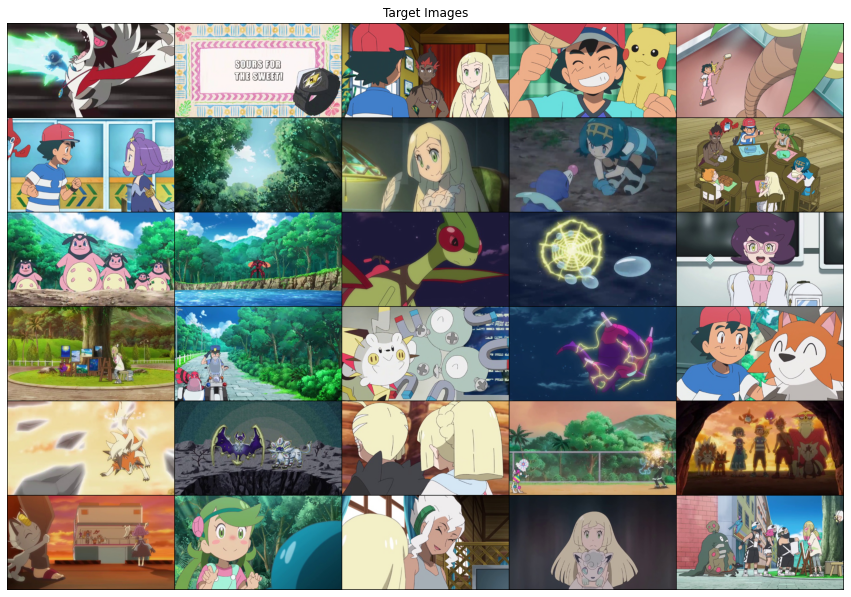

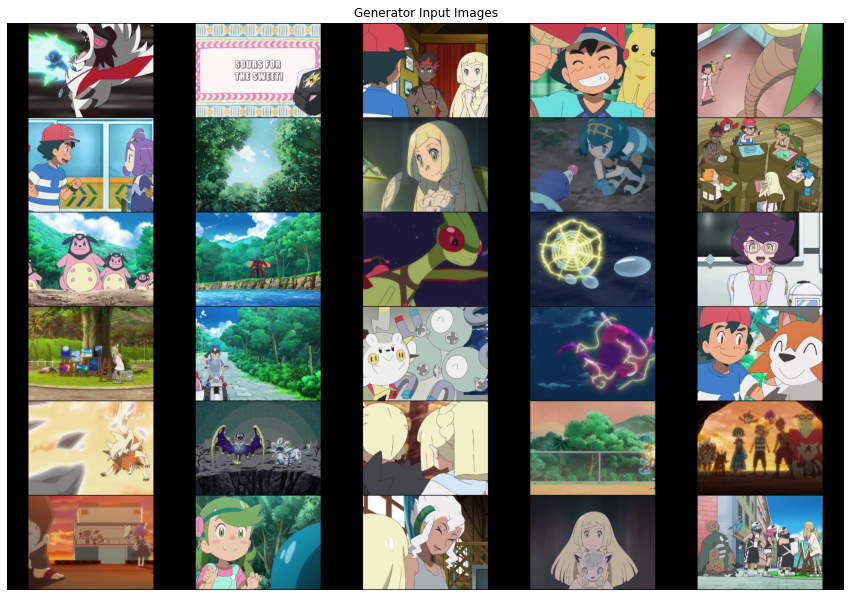

In [12]:
# Plot some training images
batch = next(iter(dataloader_train))

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

batch = apply_mask(batch, IMG_WIDTH, SINGLE_SIDE)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.title('Generator Input Images')
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

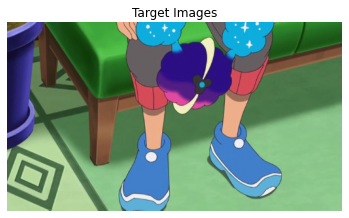

In [13]:
image = dataloader_train.dataset.__getitem__(TRAIN_REFERENCE_INDEX)
image = apply_scale(image)
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Target Images')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


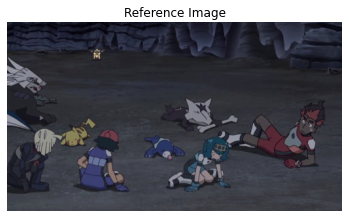

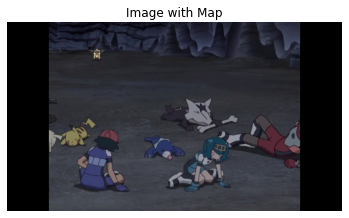

In [55]:
# This is the testing reference image
image = dataloader_val.dataset.__getitem__(2780)
image = apply_scale(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

image = apply_mask(image, IMG_WIDTH, SINGLE_SIDE)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Image with Map')
plt.imshow(np.transpose(vutils.make_grid(image).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


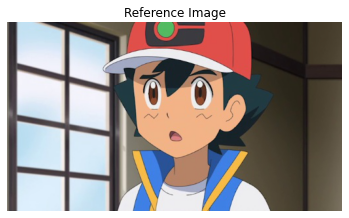

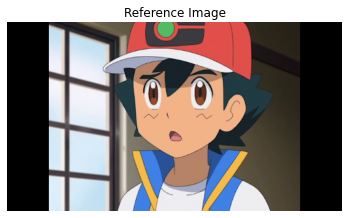

In [127]:
# This is the testing reference image
image = dataloader_test.dataset.__getitem__(11000)
image = apply_scale(image)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(image, padding=2, nrow=4).cpu(),(1,2,0)))

image = apply_mask(image, IMG_WIDTH, SINGLE_SIDE)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title('Reference Image')
plt.imshow(np.transpose(vutils.make_grid(image, padding=2, nrow=4).cpu(),(1,2,0)))